### Домашнее задание №5
1. Для нашего пайплайна (Набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности   
Ссылки:  
http://hyperopt.github.io/hyperopt/  
https://arxiv.org/pdf/1907.03947.pdf  
https://arxiv.org/pdf/1802.02301.pdf  
https://arxiv.org/list/stat.ML/recent  
https://scikit-learn.org/stable/modules/grid_search.html  
https://scikit-learn.org/stable/modules/compose.html  

#### 1. Для нашего пайплайна (Набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    Преобразователь для выбора одного столбца из фрейма данных для выполнения дополнительных преобразований в
    Использовать для числовых столбцов в данных
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        # print(test_columns)
        for col_ in self.columns:
            # print(col_)
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', NumberSelector(key='Balance')),
                ( 'std_scaler', StandardScaler())
            ])
gender.fit(X_train)
gender.transform(X_test)

array([[0.88494297],
       [0.43586703],
       [0.31486378],
       ...,
       [0.30819395],
       [0.55698791],
       [0.7006957 ]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список. Сделаем это в цикле

In [12]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ( 'std_scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [13]:
final_transformers

[('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('Gender',
  Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))])),
 ('Tenure',
  Pipeline(steps=[('selector', FeatureSelector(column='Tenure')),
                  ('ohe', OHEEncoder(key='Tenure'))])),
 ('HasCrCard',
  Pipeline(steps=[('selector', FeatureSelector(column='HasCrCard')),
                  ('ohe', OHEEncoder(key='HasCrCard'))])),
 ('IsActiveMember',
  Pipeline(steps=[('selector', FeatureSelector(column='IsActiveMember')),
                  ('ohe', OHEEncoder(key='IsActiveMember'))])),
 ('CreditScore',
  Pipeline(steps=[('selector', NumberSelector(key='CreditScore')),
                  ('std_scaler', StandardScaler())])),
 ('Age',
  Pipeline(steps=[('selector', NumberSelector(key='Age')),
                  ('std_scaler', StandardScaler())])),
 ('Balance',
  Pipeline(st

Объединим все это в единый пайплайн

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

#### 1.1. Получим прогноз с использованием RandomForestClassifier и посмотрим метрики

In [15]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [16]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('std_scaler',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [18]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


1875

Отрисуем матрицу ошибок

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


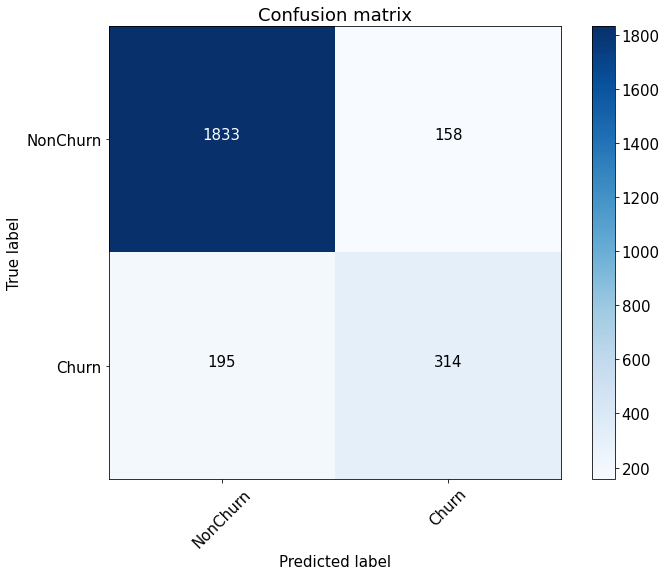

In [21]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[fscore_func])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [22]:
roc_auc_score(y_test, preds)

0.8636990228128739

#### 1.2. Получим прогноз с использованием HistGradientBoostingClassifier и посмотрим метрики

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', HistGradientBoostingClassifier(random_state=42)),
])

Обучим модель

In [24]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('std_scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

In [25]:
#наши прогнозы для тестовой выборки
preds_boost = pipeline.predict_proba(X_test)[:, 1]
preds_boost[:10]

array([0.54389213, 0.22682901, 0.15073524, 0.04724167, 0.02044665,
       0.89528078, 0.02343502, 0.10856729, 0.0973683 , 0.70286661])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

b=1
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

# fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.367224, F-Score=0.647, Precision=0.637, Recall=0.658


Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1800  191]
 [ 175  334]]


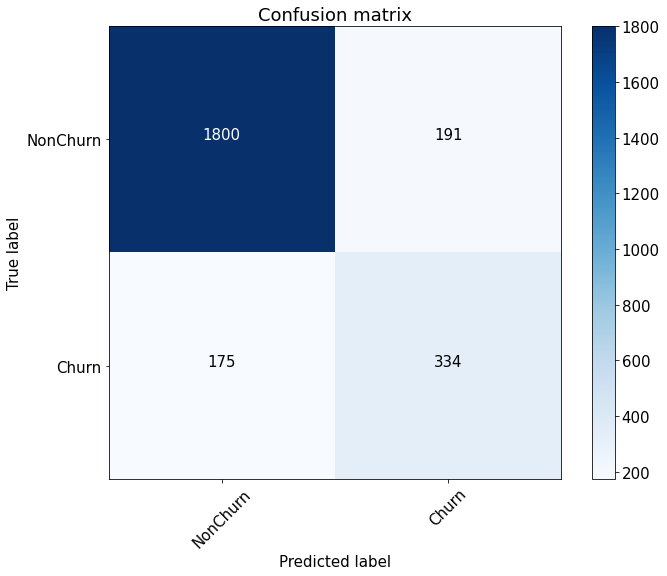

In [27]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [28]:
roc_auc_score(y_test, preds)

0.8636990228128739

#### 1.3. Получим прогноз с использованием LogisticRegression и посмотрим метрики

In [29]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
])

Обучим модель

In [30]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('std_scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(random_state=42))])

In [31]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


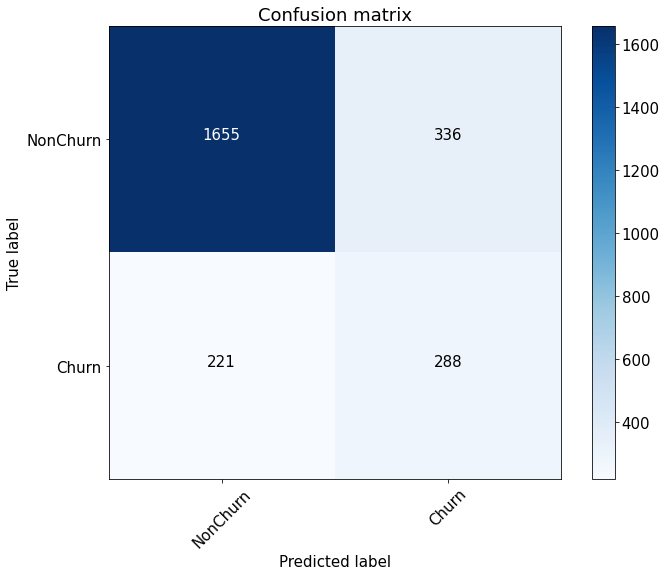

In [33]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [34]:
roc_auc_score(y_test, preds)

0.7720774921330664

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Выбор наиболее подходящей DS-метрика зависит от бюджета и затрат на привлечение и выручке, которую сгенерирует удержанный клиент. Если затраты велики в отношении к выручке, то лучше использовать Precision, чтобы не распылять бюджет. Иначе - Recall. Пока мы не считали экономику, можно не привязываться к конкретному порогу для максимизации Precision и Recall, а воспользоваться для выбора модели метрику AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). На основе этой метрики лучшей моделью является HistGradientBoostingClassifier

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Best Threshold=0.367224, F-Score=0.647, Precision=0.637, Recall=0.658
Confusion matrix, without normalization
[[1800  191]
 [ 175  334]]


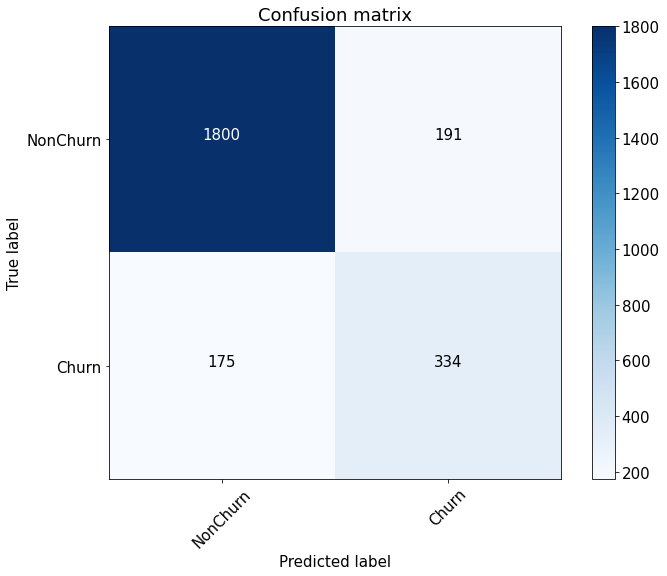

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

b=1
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

# fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для расчета нам достаточно знать два параметра: TP и TN. Зная их можно рассчитать экономическую эффективность от удержания клиентов по формуле  

                                                           profit = (TP * 2) - (TP * 1) - (FP * 1)

TN и FN не принимают участие в рассчетах, поскольку мы их определили как клиентов не попадающих в отток и следовательно маркетинговые воздействия на них оказывать не будем и соответсвенно деньги тратить не будем. 

In [36]:
# Посчитаем profit
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
profit = (TP * 2) - (TP * 1) - (FP * 1)
profit

143

Видим, что при эффективности данной модели и определенном пороге мы заработаем от деятельности по удержанию клиентов 143 доллара. Посмотрим при каком пороге данный показатель у этой модели максимальный.

In [37]:
# Рассчитаем прибыль при каждом пороге
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

b=1
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
profit_list = []
for tr in np.arange(1, len(precision) - 1, 1):
    cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[tr])
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    profit = (TP * 2) - (TP * 1) - (FP * 1)
    profit_list.append(profit)

In [38]:
# Найдем порог с максимальной прибылью
thresholds[np.argmax(profit_list)]

0.6678282705705304

In [39]:
# Посмотрим прибыль при данном пороге
profit_list[np.argmax(profit_list)]

182

Confusion matrix, without normalization
[[1950   41]
 [ 287  222]]


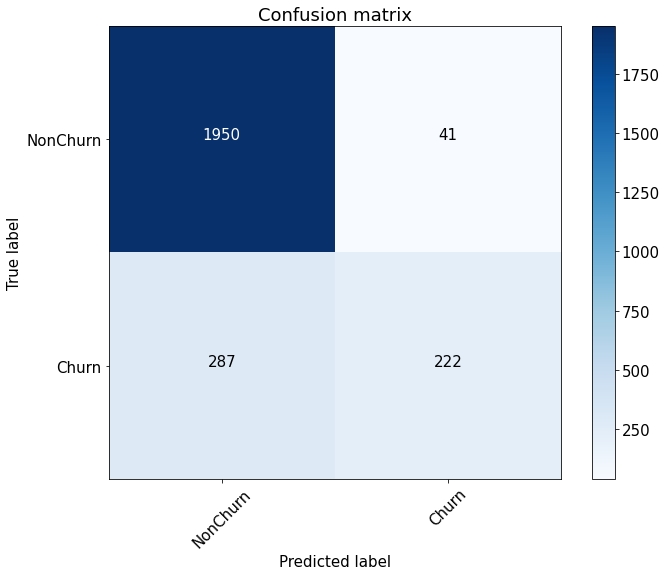

In [40]:
cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[np.argmax(profit_list)])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Вывод: Наибольшая экономическая эффективность данной модели достигается при пороге 0.667. Прибыль при этом составляет 182 доллара.

#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

### Пример с перебором параметров с помощью GridSearch

In [41]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', HistGradientBoostingClassifier(random_state=42)),
])

Сетка с параметрами

In [42]:
from sklearn.model_selection import GridSearchCV

params={'classifier__learning_rate':[0.1, 0.2],
        'classifier__max_iter':[500, 600],
        'classifier__max_depth':[2, 3],
        'classifier__l2_regularization':[0.3, 0.4]

        }

Запускаем перебор

In [43]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__l2_regularization': 0.3,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 2,
 'classifier__max_iter': 600}

Обучаем модель уже с новыми параметрами

In [44]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', HistGradientBoostingClassifier(max_depth=2, learning_rate=0.1, 
                                          max_iter=500, l2_regularization=0.3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('std_scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 HistGradientBoostingClassifier(l2_regularization=0.3,
                                                max_depth=2, max_iter=500,
                                                random_state=42))])

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


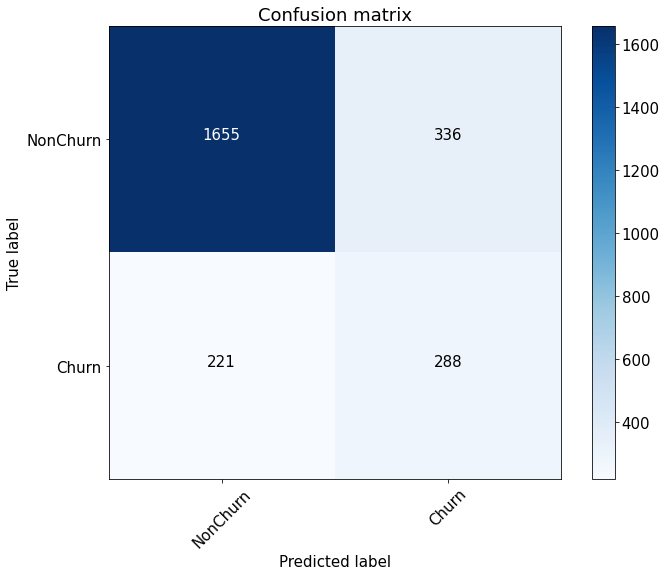

In [45]:
preds_boost = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [46]:
roc_auc_score(y_test, preds_boost)

0.8725285395280727

Метрики немного стали выше

#### 5. (опционально) Еще раз провести оценку экономической эффективности 

In [47]:
# Посчитаем profit
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
profit = (TP * 2) - (TP * 1) - (FP * 1)
profit

-48

Видим, что при эффективности данной модели и определенном пороге мы заработаем от деятельности по удержанию клиентов 156 доллара. Посмотрим при каком пороге данный показатель у этой модели максимальный.

In [48]:
# Рассчитаем прибыль при каждом пороге
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

b=1
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
profit_list = []
for tr in np.arange(1, len(precision) - 1, 1):
    cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[tr])
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    profit = (TP * 2) - (TP * 1) - (FP * 1)
    profit_list.append(profit)

In [49]:
# Найдем порог с максимальной прибылью
thresholds[np.argmax(profit_list)]

0.6072149779983256

In [50]:
# Посмотрим прибыль при данном пороге
profit_list[np.argmax(profit_list)]

188

Confusion matrix, without normalization
[[1946   45]
 [ 277  232]]


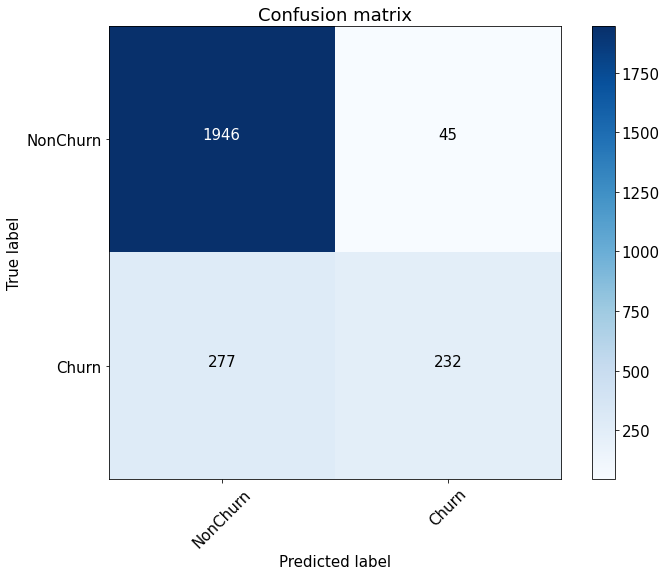

In [51]:
cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[np.argmax(profit_list)])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Вывод: Наибольшая экономическая эффективность данной модели достигается при пороге 0.607. Прибыль при этом составляет 188 доллара, что на 3.3% лучше предыдущего варианта.